## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

# The Grid World

The setup here is *almost* identical as the simplest version described in the notes.  The only difference is that this agent is allowed to move diagonally in a single step; this is slightly easier to code since I can have two actions (one for left/right, and another for up/down), and write the dynamics as the trivial linear system ${\bf x}[n+1] = {\bf u}[n].$  Only the value iteration code needs to know that the states and actions are actually restricted to the integers.

The obstacle (pit of despair) is provided by the method below.  Play around with it!  The rest of the code is mostly to support visualization.

TODO: Pull a few more of the visualization frills from my old [code](https://github.com/RobotLocomotion/drake/blob/last_sha_with_original_matlab/drake/examples/GridWorld.m).  At very least, I want to draw the vector field of the resulting policy.


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from pydrake.all import DiagramBuilder, LinearSystem, Simulator
from pydrake.systems.controllers import (DynamicProgrammingOptions,
                                         FittedValueIteration)

from underactuated.jupyter import SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()


time_step = 1
# TODO(russt): Support discrete-time systems in the dynamic programming code, and use this properly.
#plant = LinearSystem(A=np.eye(2), B=np.eye(2), C=np.eye(2), D=np.zeros((2,2)), time_period=time_step)
# for now, just cheat because I know how to make the discrete system as a continuous that will be discretized.
plant = LinearSystem(A=np.zeros((2,2)), B=np.eye(2), C=np.eye(2), D=np.zeros((2,2)))
simulator = Simulator(plant)
options = DynamicProgrammingOptions()

xbins = range(0, 21)
ybins = range(0, 21)
state_grid = [set(xbins), set(ybins)]

input_grid = [set([-1, 0, 1]), set([-1, 0, 1])]

goal = [2, 8]

def obstacle(x):
    return x[0]>=6 and x[0]<=8 and x[1]>=4 and x[1]<=7

[X, Y] = np.meshgrid(xbins, ybins)

def draw(iteration, mesh, cost_to_go, policy):
    plt.title("iteration " + str(iteration))
    J = np.reshape(cost_to_go, X.shape)
    im = ax.imshow(J, cmap=cm.jet)
    fig.canvas.draw()
    im.remove()

    # Slow down so you can watch the iterations of the algorithm.
    plt.pause(0.5)  

if plt_is_interactive:
  options.visualization_callback = draw

def solve():
    policy, cost_to_go = FittedValueIteration(simulator, cost_function, state_grid,
                                              input_grid, time_step, options)

    J = np.reshape(cost_to_go, X.shape)
    im = ax.imshow(J, cmap=cm.jet)
    plt.colorbar(im)
    return policy


Let's define a minimum-time cost to the goal, and run value iteration.

<IPython.core.display.Javascript object>


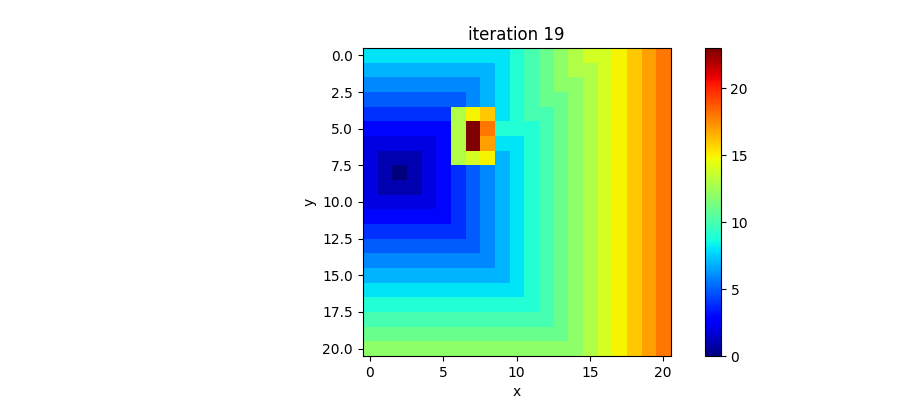

[2020-10-28 07:08:02.345] [console] [info] Computing transition and cost matrices.
[2020-10-28 07:08:02.727] [console] [info] Done computing transition and cost matrices.
[2020-10-28 07:08:02.729] [console] [info] Running value iteration.
[2020-10-28 07:08:14.302] [console] [info] Value iteration converged to requested tolerance.


In [3]:
def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x = np.round(x)
    if obstacle(x):
        return 10
    if np.array_equal(x, goal):
        return 0
    return 1
    
cost_function = min_time_cost
options.convergence_tol = .1;

fig = plt.figure(figsize=(9, 4))
ax = fig.gca()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Cost-to-Go")

policy = solve()

Your turn.  Change the cost.  Change the obstacles.